In [1]:
import numpy as np
import networkx as nx

In [2]:
sc.master

'spark://master:7077'

In [3]:
filename = './USA-road-d.NY.co/USA-road-d.NY.co' # txt文件和当前脚本在同一目录下，所以不用写具体路径
Efield = []
x_list = []
y_list = []
with open(filename, 'r') as file_to_read:
    count = 0
    while True:
        item = []
        lines = file_to_read.readline() # 整行读取数据
        if not lines:
            break
        v, id, x_loc, y_loc = [i for i in lines.split()] # 将整行数据分割处理，如果分割符是空格，括号里就不用传入参数，如果是逗号， 则传入‘，'字符。
        item.append(int(id))  # 添加新读取的数据
        item.append(int(x_loc))
        item.append(int(y_loc))
        Efield.append(item)
        x_list.append(int(x_loc))
        y_list.append(int(y_loc))
        count += 1
"""         if count % 1000 == 0:
            print("count:",count)
            print("item:",item) """
city_show_num = 4000
x_list = np.array(x_list)[0:city_show_num]
y_list = np.array(y_list)[0:city_show_num]

city_co = np.array(Efield)
print(city_co)
print(x_list)

[[        1 -73530767  41085396]
 [        2 -73530538  41086098]
 [        3 -73519366  41048796]
 ...
 [   264344 -73820681  40994683]
 [   264345 -73714376  41004205]
 [   264346 -73917690  41291980]]
[-73530767 -73530538 -73519366 ... -73515866 -73512266 -73511366]


## 读取图连通关系

In [4]:
filename = './USA-road-d.NY.gr/USA-road-d.NY.gr' # txt文件和当前脚本在同一目录下，所以不用写具体路径
Efield = []
with open(filename, 'r') as file_to_read:
    count = 0
    while True:
        item = []
        lines = file_to_read.readline() # 整行读取数据
        if not lines:
            break
        a, v_i, v_j, dis_ij = [i for i in lines.split()] # 将整行数据分割处理，如果分割符是空格，括号里就不用传入参数，如果是逗号， 则传入‘，'字符。
        item.append(int(v_i))  # 添加新读取的数据
        item.append(int(v_j))
        item.append(int(dis_ij))
        Efield.append(item)
        count += 1
"""         if count % 1000 == 0:
            print("count:",count)
            print("item:",item)  """

dis_table = np.array(Efield)
print(len(dis_table))
print(dis_table)

733846
[[     1      2    803]
 [     2      1    803]
 [     3      4    158]
 ...
 [263813 263466    106]
 [261228 259707    389]
 [259707 261228    389]]


In [5]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 20))

""" for edge in dis_table[:1000]:
    x_1 = city_co[edge[0],1]
    x_2 = city_co[edge[1],1]
    X = [x_1, x_2]
    y_1 = city_co[edge[0],2]
    y_2 = city_co[edge[1],2]
    Y = [y_1, y_2]
    plt.plot(X, Y, color = 'r', linewidth = 0.1) """
# plt.savefig("map.png")
plt.scatter(x_list,y_list,s=0.5)
plt.show()

<Figure size 2000x2000 with 1 Axes>

In [6]:
# -*- coding: utf-8 -*-
import random
import copy
import time
import numpy as np
import sys
import math
import tkinter #//GUI模块
import threading
import pandas as pd
from functools import reduce

# 参数
'''
ALPHA:信息启发因子，值越大，则蚂蚁选择之前走过的路径可能性就越大
      ，值越小，则蚁群搜索范围就会减少，容易陷入局部最优
BETA:Beta值越大，蚁群越就容易选择局部较短路径，这时算法收敛速度会
     加快，但是随机性不高，容易得到局部的相对最优
'''
(ALPHA, BETA, RHO, Q) = (1.0,2.0,0.005,5000)
# 城市数，蚁群
(city_num, ant_num) = (264346, 50)
distance_nx_graph = nx.DiGraph()
pheromone_nx_graph = nx.DiGraph()




In [7]:
# from classAnt import Ant
'''
def update_pheromone_gragh(ants,target):

    # 获取每只蚂蚁在其路径上留下的信息素
    for ant in ants:
        #如果这条路无法到达，则不应该更新信息素
        if ant.path[-1] != target:
            continue
        for i in range(1,len(ant.path)):
            start, end = ant.path[i-1], ant.path[i]
            # 在路径上的每两个相邻城市间留下信息素，与路径总距离反比
            #temp_pheromone[start][end] += Q / ant.total_distance
            # temp_vertex = pheromone_adja_graph.vertList[start]
            temp_pheromone = pheromone_nx_graph.get_edge_data(start, end)['weight'] * (1-RHO)
            # 更新所有城市之间的信息素，旧信息素衰减加上新迭代信息素
            temp_pheromone += Q / ant.total_distance
            pheromone_nx_graph.add_weighted_edges_from([(start,end,temp_pheromone)])'''
def update_pheromone_gragh(ant_searched,target):
    #path[0]为路径长度，path[1]为路径list
    # 获取每只蚂蚁在其路径上留下的信息素
    for path in ant_searched:
        #如果这条路无法到达，则不应该更新信息素
        if path[1][-1] != target:
            continue
        k = 1 / path[0]
        for i in range(1,len(path[1])):
            start, end = path[1][i-1], path[1][i]
            # 在路径上的每两个相邻城市间留下信息素，与路径总距离反比
            #temp_pheromone[start][end] += Q / ant.total_distance
            # temp_vertex = pheromone_adja_graph.vertList[start]
            temp_pheromone = bc_pheromone_nx_graph.value.get_edge_data(start, end)['weight'] * (1-RHO)
            # 更新所有城市之间的信息素，旧信息素衰减加上新迭代信息素
            temp_pheromone += Q * k
            pheromone_nx_graph.add_weighted_edges_from([(start,end,temp_pheromone)])
            
def initial_map(city_num):
        # 初始化邻接表
    distance_nx_graph.clear()
    pheromone_nx_graph.clear()
    initial_pheromone = 1
    for item in dis_table:
        if item[0] <= city_num and item[1] <= city_num:
            distance_nx_graph.add_weighted_edges_from([(item[0],item[1],item[2])])
            pheromone_nx_graph.add_weighted_edges_from([(item[0],item[1],initial_pheromone)])
    

def initial_ants(sc, start, target):
    # global ants
    ants = [Ant(ID,target,start,city_num,ALPHA,BETA,RHO,Q) for ID in range(ant_num)]  # 初始蚁群
    ants_RDD = sc.parallelize(ants)
    return(ants_RDD)

def search_path(start,target,city_co):
    
    
    #best_ant = Ant(-1,target,start)                          # 初始最优解
    #best_ant.total_distance = np.inf           # 初始最好的蚂蚁
    best_distance = np.inf
    
    iter = 1

    while True:
        # 遍历每一只蚂蚁
        tic = time.time()
        count = 0
        for ant in ants:
            # 搜索一条路径
            ant.search_path(distance_nx_graph,pheromone_nx_graph,city_co)
            # 与当前最优蚂蚁比较
            #print(ant.path)
            #print(ant.total_distance)
            if ant.total_distance < best_distance and ant.path[-1] == target:
                # 更新最优解
                #best_ant = copy.deepcopy(ant)
                best_path = ant.path
                best_distance = ant.total_distance
                print('found a path!')

        # 更新信息素
        update_pheromone_gragh(ants,target)
        if best_distance < np.inf:
            toc = time.time()
            gap = toc-tic
            path_str = '%d' % best_path[0]
            # 给定策略然后进行选择
            for i in range(len(best_path) - 1):
                """ if strategy_graph[best_path[i]][best_path[i+1]] == 1:
                    path_str = path_str + '--freeway--'
                elif strategy_graph[best_path[i]][best_path[i+1]] == 2:
                    path_str = path_str + '--road--' """
                path_str = path_str + '------' + '%d' % best_path[i+1]
            # 给定策略的概率，按概率进行选择?这样似乎是不太合理的。因为只有策略确定了之后，才有相应的评价体系，先后顺序不能乱
            """ for i in range(len(best_path) - 1):
                if prob_graph[best_path[i]][best_path[i+1]] >= 0:
                    # 二项分布随机数
                    the_choice = np.random.binomial(1,prob_graph[best_path[i]][best_path[i+1]],size = 1)
                    print(prob_graph[best_path[i]][best_path[i+1]])
                    if the_choice == 1:
                        path_str = path_str + '--freeway--'
                    elif the_choice == 0:
                        path_str = path_str + '--road--'
                    path_str = path_str + '%d' % best_path[i+1] """
            print (u"迭代次数：",iter,u"最佳路径总距离：",int(best_distance),"路径为：",path_str,"搜索时长：",gap)
        else:
            print(u"迭代次数：",iter,u"无法到达！")
        iter += 1


显示起终点在地图中的相对位置

In [8]:
# 设置起点和终点
start = 297
target = 1000

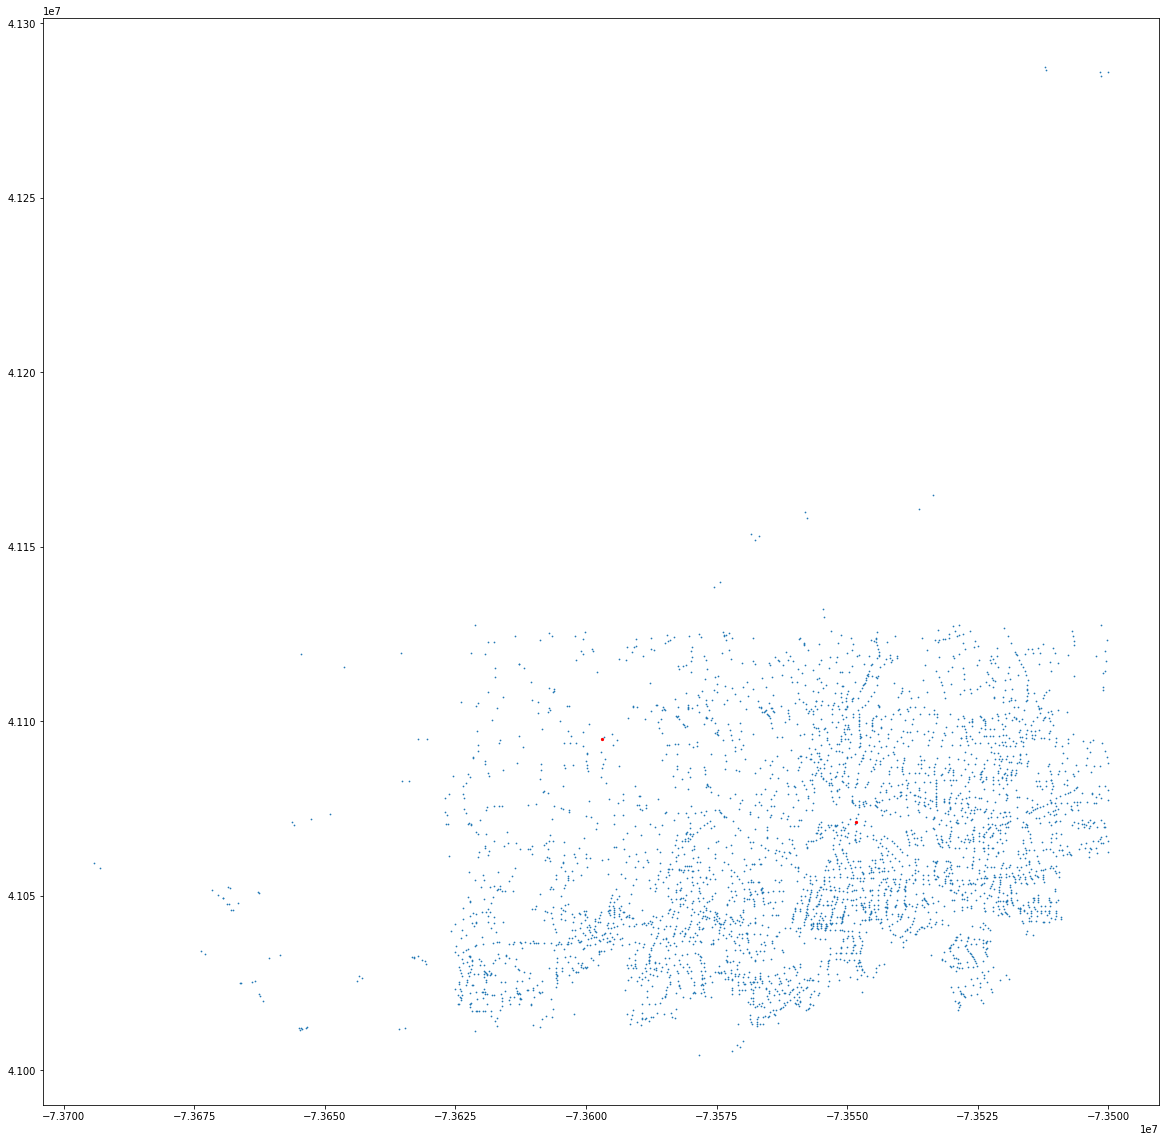

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 20))
plt.scatter(x_list,y_list,s=0.5)
""" for edge in dis_table[:1000]:
    x_1 = city_co[edge[0],1]
    x_2 = city_co[edge[1],1]
    X = [x_1, x_2]
    y_1 = city_co[edge[0],2]
    y_2 = city_co[edge[1],2]
    Y = [y_1, y_2]
    plt.plot(X, Y, color = 'r', linewidth = 0.1) """
# plt.savefig("map.png")
x_start = city_co[start,1]
x_target = city_co[target,1]
X = [x_start, x_target]
y_start = city_co[start,2]
y_target = city_co[target,2]
Y = [y_start, y_target]
plt.scatter(X,Y,c = 'r', s=5)
plt.show()

开始测试搜索

In [10]:
initial_map(city_num)
#设置广播变量


In [11]:
bc_distance_nx_graph = sc.broadcast(distance_nx_graph)
bc_pheromone_nx_graph = sc.broadcast(pheromone_nx_graph)
bc_city_co = sc.broadcast(city_co)

In [12]:
sc.addPyFile("hdfs://master:9000/ant/classAnt.py")
SparkConf().set("spark.defalut.parallelism", ant_num)
from classAnt import *


ants_RDD = initial_ants(sc, start,target).persist()
print(ants_RDD)

ParallelCollectionRDD[0] at parallelize at PythonRDD.scala:195


In [13]:

the_iter = 1
best_path_distance = np.inf
best_path = []
while(1):
    tic = time.time()
    ants_RDD_searched = ants_RDD.map(lambda x:x.search_path(bc_distance_nx_graph.value, bc_pheromone_nx_graph.value, bc_city_co.value))
    ants_searched = ants_RDD_searched.collect()
    #ants_searched = ants_RDD_searched.show()
    
    t_collect = time.time()
    print("collect time:", t_collect - tic)
    
    distance_list = []
    for i in range(ant_num):
        distance_list.append(ants_searched[i][0])
    min_distance = min(distance_list)
    if min_distance < best_path_distance:
        print("found a path!")
        print("distance:", min_distance)
        print(ants_searched[distance_list.index(min_distance)][1])
        best_path_distance = min_distance
        best_path = ants_searched[distance_list.index(min_distance)][1]
    
    t_findmin =time.time()
    
    update_pheromone_gragh(ants_searched,target)
    t_update = time.time()
    print("update time:", t_update - t_findmin)
    
    bc_pheromone_nx_graph.unpersist()
    bc_pheromone_nx_graph = sc.broadcast(pheromone_nx_graph)
    t_bc = time.time()
    print("bc time:", t_bc - t_update)
    
    
    if best_path_distance < np.inf:
        print (u"迭代次数：",the_iter,u"最佳路径总距离：",int(best_path_distance),"路径为：",best_path)
    else:
        print(u"迭代次数：",the_iter,u"无法到达！")
        
    toc = time.time()
    gap = toc-tic
    print("搜索总时长：",gap)
    
    the_iter += 1


collect time: 844.7172405719757
found a path!
distance: 57146.0
[297, 343, 320, 342, 345, 347, 349, 364, 365, 366, 659, 660, 663, 677, 755, 901, 906, 924, 925, 927, 929, 928, 944, 948, 957, 958, 959, 960, 962, 1002, 1001, 1008, 1003, 1000]
update time: 3.06622052192688
bc time: 13.210300207138062
迭代次数： 1 最佳路径总距离： 57146 路径为： [297, 343, 320, 342, 345, 347, 349, 364, 365, 366, 659, 660, 663, 677, 755, 901, 906, 924, 925, 927, 929, 928, 944, 948, 957, 958, 959, 960, 962, 1002, 1001, 1008, 1003, 1000]
搜索总时长： 860.9956111907959
collect time: 609.9582250118256
update time: 3.026655435562134
bc time: 12.687834024429321
迭代次数： 2 最佳路径总距离： 57146 路径为： [297, 343, 320, 342, 345, 347, 349, 364, 365, 366, 659, 660, 663, 677, 755, 901, 906, 924, 925, 927, 929, 928, 944, 948, 957, 958, 959, 960, 962, 1002, 1001, 1008, 1003, 1000]
搜索总时长： 625.6752989292145
collect time: 388.40195775032043
update time: 3.0781607627868652
bc time: 13.459500551223755
迭代次数： 3 最佳路径总距离： 57146 路径为： [297, 343, 320, 342, 345, 347, 3

KeyboardInterrupt: 

In [ ]:
print(ants_RDD_searched)

In [15]:
print(ants_searched)

[(inf, [255, 274, 273, 251, 14, 237, 222, 232, 221, 231, 261, 101, 250, 4811, 4809, 4810, 4812, 4814, 236, 239, 240, 247]), (inf, [255, 276, 278, 6500]), (inf, [255, 229, 228, 227, 225, 223, 222, 232, 221, 231, 261, 101, 100, 234, 233]), (inf, [255, 276, 278, 6500]), (inf, [255, 276, 277]), (inf, [255, 274, 275]), (inf, [255, 274, 273, 251, 252, 2315]), (inf, [255, 274, 273, 251, 252, 1549, 246, 245, 240, 247]), (inf, [255, 274, 273, 251, 252, 1549, 1552, 1556, 1553, 1557, 1558, 1586, 1589, 1590]), (inf, [255, 274, 273, 251, 252, 1549, 246, 245, 242, 243])]


In [32]:
ants_RDD_searched_2 = ants_RDD.map(lambda x: x.search_path(bc_distance_nx_graph.value, bc_pheromone_nx_graph.value, bc_city_co.value))
ants_searched_2 = ants_RDD_searched_2.collect()
print(ants_searched_2)

[(inf, [255, 274, 273, 251, 252, 1549, 246, 245, 240, 247]), (inf, [255, 274, 273, 251, 252, 2315]), (inf, [255, 276, 277]), (inf, [255, 229, 256, 257, 259]), (inf, [255, 274, 273, 251, 252, 1549, 1552, 1554]), (inf, [255, 276, 278, 6500]), (inf, [255, 276, 278, 272, 271, 279, 280, 282, 283, 379]), (inf, [255, 229, 256, 257, 258]), (inf, [255, 276, 278, 6500]), (inf, [255, 276, 277])]


In [20]:
ants_searched[1]

(inf, [255, 276, 278, 6500])

In [14]:
print(RDD_distance_list.index(min(RDD_distance_list)))

0


In [13]:
import random
search_path(start,target,city_co)

迭代次数： 1 无法到达！
迭代次数： 2 无法到达！
迭代次数： 3 无法到达！
迭代次数： 4 无法到达！
迭代次数： 5 无法到达！
迭代次数： 6 无法到达！
迭代次数： 7 无法到达！
迭代次数： 8 无法到达！
迭代次数： 9 无法到达！
迭代次数： 10 无法到达！
迭代次数： 11 无法到达！
迭代次数： 12 无法到达！
迭代次数： 13 无法到达！
迭代次数： 14 无法到达！
迭代次数： 15 无法到达！
found a path!
迭代次数： 16 最佳路径总距离： 43105 路径为： 255------276------278------271------279------280------282------269------267------266------214------213------212------211------210------298------300 搜索时长： 0.03349661827087402
迭代次数： 17 最佳路径总距离： 43105 路径为： 255------276------278------271------279------280------282------269------267------266------214------213------212------211------210------298------300 搜索时长： 0.03394365310668945
迭代次数： 18 最佳路径总距离： 43105 路径为： 255------276------278------271------279------280------282------269------267------266------214------213------212------211------210------298------300 搜索时长： 0.03284740447998047
迭代次数： 19 最佳路径总距离： 43105 路径为： 255------276------278------271------279------280------282------269------267------266------214------213------212------211------210---

迭代次数： 58 最佳路径总距离： 43105 路径为： 255------276------278------271------279------280------282------269------267------266------214------213------212------211------210------298------300 搜索时长： 0.034371376037597656
迭代次数： 59 最佳路径总距离： 43105 路径为： 255------276------278------271------279------280------282------269------267------266------214------213------212------211------210------298------300 搜索时长： 0.03503680229187012
迭代次数： 60 最佳路径总距离： 43105 路径为： 255------276------278------271------279------280------282------269------267------266------214------213------212------211------210------298------300 搜索时长： 0.031473636627197266
迭代次数： 61 最佳路径总距离： 43105 路径为： 255------276------278------271------279------280------282------269------267------266------214------213------212------211------210------298------300 搜索时长： 0.03602433204650879
迭代次数： 62 最佳路径总距离： 43105 路径为： 255------276------278------271------279------280------282------269------267------266------214------213------212------211------210------298------300 搜索时长： 0.0

迭代次数： 102 最佳路径总距离： 43105 路径为： 255------276------278------271------279------280------282------269------267------266------214------213------212------211------210------298------300 搜索时长： 0.03584122657775879
迭代次数： 103 最佳路径总距离： 43105 路径为： 255------276------278------271------279------280------282------269------267------266------214------213------212------211------210------298------300 搜索时长： 0.03397536277770996
迭代次数： 104 最佳路径总距离： 43105 路径为： 255------276------278------271------279------280------282------269------267------266------214------213------212------211------210------298------300 搜索时长： 0.035918235778808594
迭代次数： 105 最佳路径总距离： 43105 路径为： 255------276------278------271------279------280------282------269------267------266------214------213------212------211------210------298------300 搜索时长： 0.03693747520446777
迭代次数： 106 最佳路径总距离： 43105 路径为： 255------276------278------271------279------280------282------269------267------266------214------213------212------211------210------298------300 搜索时长：

迭代次数： 145 最佳路径总距离： 43105 路径为： 255------276------278------271------279------280------282------269------267------266------214------213------212------211------210------298------300 搜索时长： 0.03679084777832031
迭代次数： 146 最佳路径总距离： 43105 路径为： 255------276------278------271------279------280------282------269------267------266------214------213------212------211------210------298------300 搜索时长： 0.033591508865356445
迭代次数： 147 最佳路径总距离： 43105 路径为： 255------276------278------271------279------280------282------269------267------266------214------213------212------211------210------298------300 搜索时长： 0.03451824188232422
迭代次数： 148 最佳路径总距离： 43105 路径为： 255------276------278------271------279------280------282------269------267------266------214------213------212------211------210------298------300 搜索时长： 0.03251791000366211
迭代次数： 149 最佳路径总距离： 43105 路径为： 255------276------278------271------279------280------282------269------267------266------214------213------212------211------210------298------300 搜索时长：

迭代次数： 189 最佳路径总距离： 43105 路径为： 255------276------278------271------279------280------282------269------267------266------214------213------212------211------210------298------300 搜索时长： 0.03297233581542969
迭代次数： 190 最佳路径总距离： 43105 路径为： 255------276------278------271------279------280------282------269------267------266------214------213------212------211------210------298------300 搜索时长： 0.03233075141906738
迭代次数： 191 最佳路径总距离： 43105 路径为： 255------276------278------271------279------280------282------269------267------266------214------213------212------211------210------298------300 搜索时长： 0.03337883949279785
迭代次数： 192 最佳路径总距离： 43105 路径为： 255------276------278------271------279------280------282------269------267------266------214------213------212------211------210------298------300 搜索时长： 0.03770256042480469
迭代次数： 193 最佳路径总距离： 43105 路径为： 255------276------278------271------279------280------282------269------267------266------214------213------212------211------210------298------300 搜索时长： 

KeyboardInterrupt: 

In [4]:
intRDD = sc.parallelize([3,1,2,5,5])
#intRDD.collect()
intRDD.take(1)

[3]

In [9]:
'''
class test():
    def __init__(self):
        self.property=0

    def test2(self):
        return self.property
'''
from classTest import *
p1 = test()
p2 = test()
a = [p1,p2]
rdd = sc.parallelize(a)
#rdd.take(1)
rdd.map(lambda x : x.test2()).collect()

[0, 0]